# Visualization: Integration Results

This notebook visualizes:
1. Method comparison (MARIO vs MaxFuse)
2. Joint embeddings (CCA, UMAP)
3. Spatial cell type mapping
4. Harmony batch correction

**Prerequisites**: Run `preprocessing.ipynb` and `integration.ipynb` first

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread
import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100
import pickle
import json
import os


In [2]:
# Load results from previous notebooks
# Run 1_preprocessing.ipynb and 2_integration.ipynb first

preprocess_dir = 'results/1_preprocessing'
integration_dir = 'results/2_integration'

# Check directories exist
for d in [preprocess_dir, integration_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(
            f"Results directory '{d}' not found. "
            f"Run the prerequisite notebooks first."
        )

# Check required files exist
required_files = [
    f'{preprocess_dir}/protein_adata.h5ad',
    f'{preprocess_dir}/rna_adata.h5ad',
    f'{preprocess_dir}/rna_adata_lognorm.h5ad',
    f'{integration_dir}/maxfuse_matching.pkl',
    f'{integration_dir}/rna_active.npy',
    f'{integration_dir}/protein_active.npy',
]
for f in required_files:
    if not os.path.exists(f):
        raise FileNotFoundError(
            f"Required file '{f}' not found. "
            f"Run the prerequisite notebooks first."
        )

# Load preprocessed data
protein_adata = sc.read_h5ad(f'{preprocess_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{preprocess_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{preprocess_dir}/rna_adata_lognorm.h5ad')
print(f"Loaded preprocessed data:")
print(f"  Protein: {protein_adata.shape}")
print(f"  RNA: {rna_adata.shape}")

# Load integration results
with open(f'{integration_dir}/maxfuse_matching.pkl', 'rb') as f:
    matching_data = pickle.load(f)
full_matching = [matching_data['rna_indices'], matching_data['protein_indices'], matching_data['scores']]
print(f"\nLoaded MaxFuse matching: {len(full_matching[0])} matches")

# Load normalized arrays
rna_shared = np.load(f'{integration_dir}/rna_shared.npy')
rna_active = np.load(f'{integration_dir}/rna_active.npy')
protein_shared = np.load(f'{integration_dir}/protein_shared.npy')
protein_active = np.load(f'{integration_dir}/protein_active.npy')
print(f"Loaded normalized arrays:")
print(f"  rna_active: {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")

# Load integration parameters
with open(f'{integration_dir}/integration_params.json', 'r') as f:
    integration_params = json.load(f)

# Extract key variables needed downstream
n_rna = rna_adata.n_obs
n_prot = protein_adata.n_obs

print(f"\nReady for visualization")

Loaded preprocessed data:
  Protein: (172181, 26)
  RNA: (9374, 18626)


FileNotFoundError: [Errno 2] No such file or directory: 'results/2_integration/maxfuse_matching.pkl'

## Step 8: Compare MaxFuse and MARIO Results

In [58]:
print("=" * 60)
print("METHOD COMPARISON")
print("=" * 60)

print(f"\nMARIO (on subsample of {n_rna_subsample} RNA, {n_prot_subsample} protein):")
print(f"  Optimal interpolation weight: {best_wt:.2f}")
print(f"  Matched RNA cells: {n_matched_filtered}/{n_rna_subsample} ({100*n_matched_filtered/n_rna_subsample:.1f}%)")
print(f"  Mean canonical correlation: {np.mean(cancor[:5]):.3f}")

print(f"\nMaxFuse (full data: {n_rna} RNA, {n_prot} protein):")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells matched: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells matched: {len(np.unique(full_matching[1]))}")
print(f"  Mean match score: {np.mean(full_matching[2]):.3f}")

METHOD COMPARISON

MARIO (on subsample of 2000 RNA, 10000 protein):
  Optimal interpolation weight: 0.11
  Matched RNA cells: 519/2000 (25.9%)
  Mean canonical correlation: 1.000

MaxFuse (full data: 9374 RNA, 172181 protein):
  Total matches: 122870
  Unique RNA cells matched: 3211
  Unique Protein cells matched: 122870
  Mean match score: 0.454


## Step 9: Joint Embedding and Visualization (MaxFuse)

**CRITICAL**: For good UMAP overlap between modalities, we need to:
1. **Refit CCA on the full matching** (not use the pivot-only CCA)
2. **Create aligned pairs** where matched RNA and protein cells have corresponding embeddings
3. **Use the matching to average multiple protein matches per RNA cell**

The default `get_embedding()` uses CCA fitted only on pivots, which doesn't generalize well.

In [59]:
# NOTE: The Fusor object is not available when loading from checkpoint.
# We will use manual CCA fitting in the next cell instead.
# This approach is actually better because it fits CCA on the full matching,
# not just the pivots that Fusor uses internally.

print("Skipping Fusor-based embedding (not available from checkpoint)")
print("Using manual CCA fitting in next cell instead - this is the recommended approach.")

Refitting CCA on full matching...
This creates properly aligned embeddings for both modalities.
RNA CCA embedding: (9374, 24)
Protein CCA embedding: (172181, 24)


In [60]:
# Alternative approach: Create aligned embeddings manually for better control
# This ensures matched cells end up close together in the embedding

from sklearn.cross_decomposition import CCA

# Build aligned arrays from the matching
# Group matches by RNA cell and average protein cells
rna_to_prot_matches = {}
for rna_idx, prot_idx, score in zip(full_matching[0], full_matching[1], full_matching[2]):
    if rna_idx not in rna_to_prot_matches:
        rna_to_prot_matches[rna_idx] = []
    rna_to_prot_matches[rna_idx].append((prot_idx, score))

# Create aligned arrays
aligned_rna = []
aligned_prot = []
aligned_rna_indices = []

for rna_idx, matches in rna_to_prot_matches.items():
    prot_indices = [m[0] for m in matches]
    # Average the matched protein cells
    aligned_rna.append(rna_active[rna_idx])
    aligned_prot.append(protein_active[prot_indices].mean(axis=0))
    aligned_rna_indices.append(rna_idx)

aligned_rna = np.array(aligned_rna)
aligned_prot = np.array(aligned_prot)
aligned_rna_indices = np.array(aligned_rna_indices)

print(f"Aligned arrays:")
print(f"  RNA: {aligned_rna.shape}")
print(f"  Protein: {aligned_prot.shape}")
print(f"  Unique RNA cells with matches: {len(aligned_rna_indices)}")

Aligned arrays:
  RNA: (3211, 18626)
  Protein: (3211, 25)
  Unique RNA cells with matches: 3211


Fitting CCA with 20 components on aligned pairs...

Canonical correlations: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of first 5: 1.000


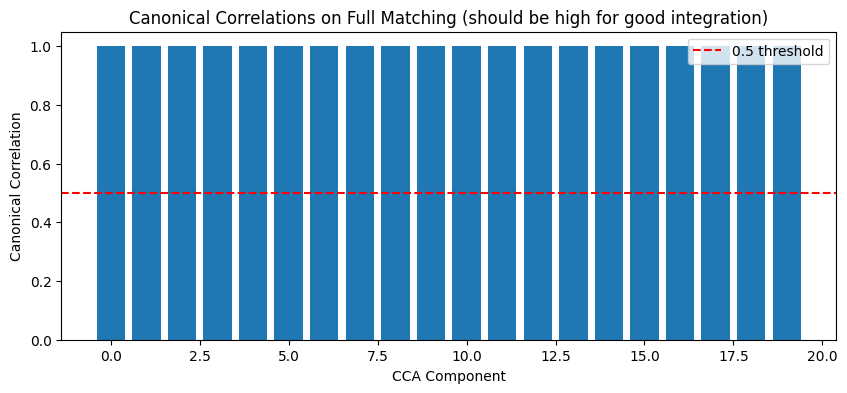

In [61]:
# Fit CCA on the aligned pairs
n_cca_components = min(20, aligned_rna.shape[1], aligned_prot.shape[1], aligned_rna.shape[0] // 2)
print(f"Fitting CCA with {n_cca_components} components on aligned pairs...")

cca = CCA(n_components=n_cca_components, max_iter=5000)
cca.fit(aligned_rna, aligned_prot)

# Transform to get CCA scores
rna_cca_scores, prot_cca_scores = cca.transform(aligned_rna, aligned_prot)

# Check the canonical correlations
cancor = np.array([np.corrcoef(rna_cca_scores[:, i], prot_cca_scores[:, i])[0, 1] 
                   for i in range(n_cca_components)])
print(f"\nCanonical correlations: {cancor[:10].round(3)}")
print(f"Mean of first 5: {cancor[:5].mean():.3f}")

# Plot canonical correlations
plt.figure(figsize=(10, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('CCA Component')
plt.ylabel('Canonical Correlation')
plt.title('Canonical Correlations on Full Matching (should be high for good integration)')
plt.axhline(y=0.5, color='r', linestyle='--', label='0.5 threshold')
plt.legend()
plt.show()

In [62]:
# Create joint embedding for visualization
# KEY INSIGHT: CCA produces X_c and Y_c that are correlated but may have different scales
# For TRUE overlap, we should AVERAGE the CCA scores of matched pairs

# Method 1: Average CCA scores (creates single unified embedding)
# This is what Seurat and other integration methods do
unified_embedding = (rna_cca_scores + prot_cca_scores) / 2

# Method 2: Concatenate but use the same embedding twice (original approach - shown for comparison)
# This keeps modalities separate but aligned
combined_cca = np.vstack([rna_cca_scores, prot_cca_scores])

print(f"Unified embedding (averaged): {unified_embedding.shape}")
print(f"Combined embedding (stacked): {combined_cca.shape}")

# Check how different the RNA and Protein CCA scores are
score_diff = np.abs(rna_cca_scores - prot_cca_scores)
print(f"\nDifference between RNA and Protein CCA scores:")
print(f"  Mean absolute difference: {score_diff.mean():.3f}")
print(f"  Max absolute difference: {score_diff.max():.3f}")

# For UMAP, we'll use the UNIFIED embedding (averaged) 
# and add both RNA and Protein markers to the same points
cca_adata_unified = ad.AnnData(unified_embedding.astype(np.float32))
cca_adata_unified.obs_names = [f"cell_{i}" for i in range(len(unified_embedding))]

# Also create the stacked version for comparison
modality_labels = ['RNA'] * len(rna_cca_scores) + ['Protein'] * len(prot_cca_scores)
cca_adata = ad.AnnData(combined_cca.astype(np.float32))
cca_adata.obs['modality'] = modality_labels
cca_adata.obs['pair_id'] = list(range(len(rna_cca_scores))) + list(range(len(prot_cca_scores)))

print(f"\nUnified AnnData: {cca_adata_unified.shape}")
print(f"Stacked AnnData: {cca_adata.shape}")

Unified embedding (averaged): (3211, 20)
Combined embedding (stacked): (6422, 20)

Difference between RNA and Protein CCA scores:
  Mean absolute difference: 0.896
  Max absolute difference: 24.242

Unified AnnData: (3211, 20)
Stacked AnnData: (6422, 20)


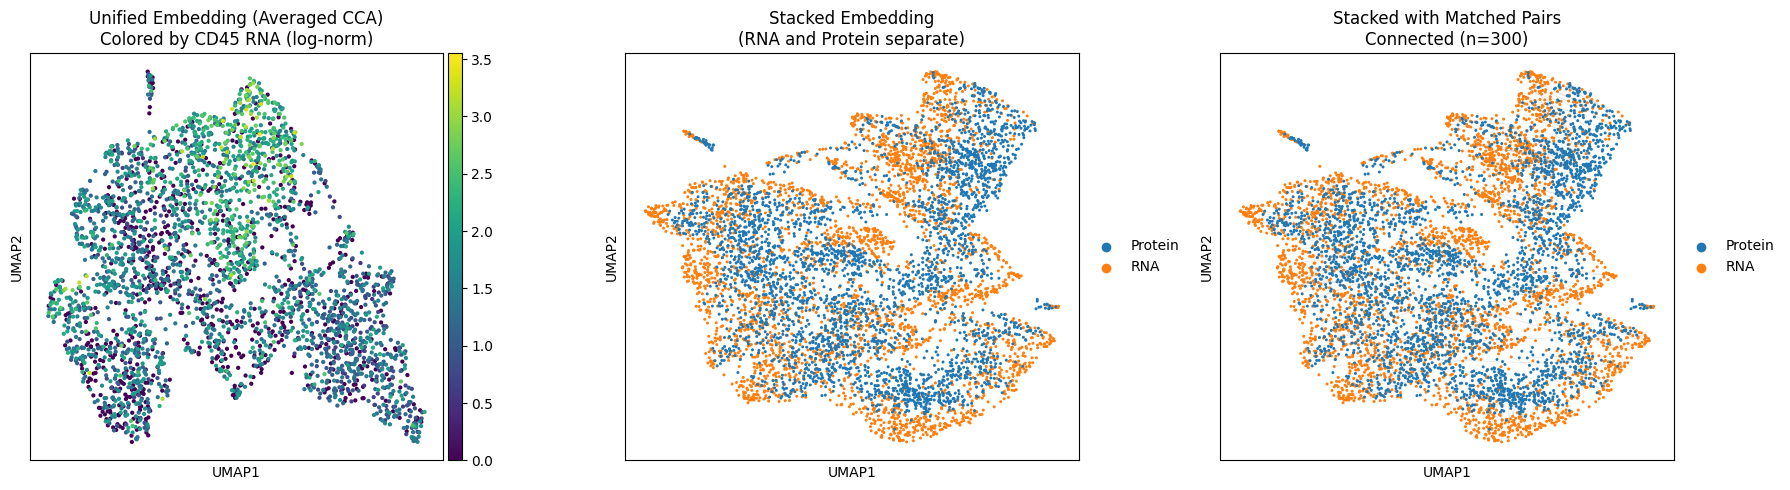


Matched pair distances in STACKED UMAP (before Harmony):
  Mean: 1.10
  Median: 1.00


In [63]:
# Compute UMAP on BOTH embeddings and compare

# 1. Unified embedding (averaged CCA scores) - TRUE integration
sc.pp.neighbors(cca_adata_unified, n_neighbors=15, use_rep='X')
sc.tl.umap(cca_adata_unified)

# 2. Stacked embedding (RNA and Protein separate)
sc.pp.neighbors(cca_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(cca_adata)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Unified embedding - colored by a marker (no modality split)
cd45_expr = np.zeros(len(unified_embedding))
if 'PTPRC' in rna_adata_lognorm.var_names:
    cd45_idx = list(rna_adata_lognorm.var_names).index('PTPRC')
    cd45_vals = rna_adata_lognorm.X[:, cd45_idx]
    if sparse.issparse(cd45_vals):
        cd45_vals = cd45_vals.toarray().flatten()
    cd45_expr = cd45_vals[aligned_rna_indices]
cca_adata_unified.obs['CD45_RNA'] = cd45_expr

sc.pl.umap(cca_adata_unified, color='CD45_RNA', ax=axes[0], show=False,
           title='Unified Embedding (Averaged CCA)\nColored by CD45 RNA', cmap='viridis')

# Stacked embedding - colored by modality
sc.pl.umap(cca_adata, color='modality', ax=axes[1], show=False,
           title='Stacked Embedding\n(RNA and Protein separate)')

# Stacked embedding with connecting lines - draw scatter FIRST, then lines ON TOP
sc.pl.umap(cca_adata, color='modality', ax=axes[2], show=False,
           title='Stacked with Matched Pairs Connected')

# Now draw connecting lines ON TOP of the scatter
umap_coords = cca_adata.obsm['X_umap']
n_pairs = len(rna_cca_scores)
n_show_pairs = 200
np.random.seed(42)
pair_sample = np.random.choice(n_pairs, min(n_show_pairs, n_pairs), replace=False)

for pair_idx in pair_sample:
    rna_umap = umap_coords[pair_idx]
    prot_umap = umap_coords[n_pairs + pair_idx]
    # Draw lines with higher visibility: thicker, darker, on top
    axes[2].plot([rna_umap[0], prot_umap[0]], [rna_umap[1], prot_umap[1]], 
                 color='black', alpha=0.4, linewidth=1.0, zorder=10)

axes[2].set_title(f'Matched Pairs Connected (n={n_show_pairs})\nBlack lines = RNA↔Protein matches')

plt.tight_layout()
plt.show()

# Quantify separation
matched_distances = np.linalg.norm(umap_coords[:n_pairs] - umap_coords[n_pairs:], axis=1)
print(f"\nMatched pair distances in UMAP:")
print(f"  Mean: {matched_distances.mean():.2f}")
print(f"  Median: {np.median(matched_distances):.2f}")
print(f"  (Shorter distances = better integration)")

MATCHED PAIR DISTANCE ANALYSIS

Distance Statistics (all 3211 matched pairs):
  Mean:   1.10
  Median: 1.00
  Std:    0.81
  Min:    0.05
  Max:    15.16

Outliers (distance > 2.71): 41 pairs (1.3%)


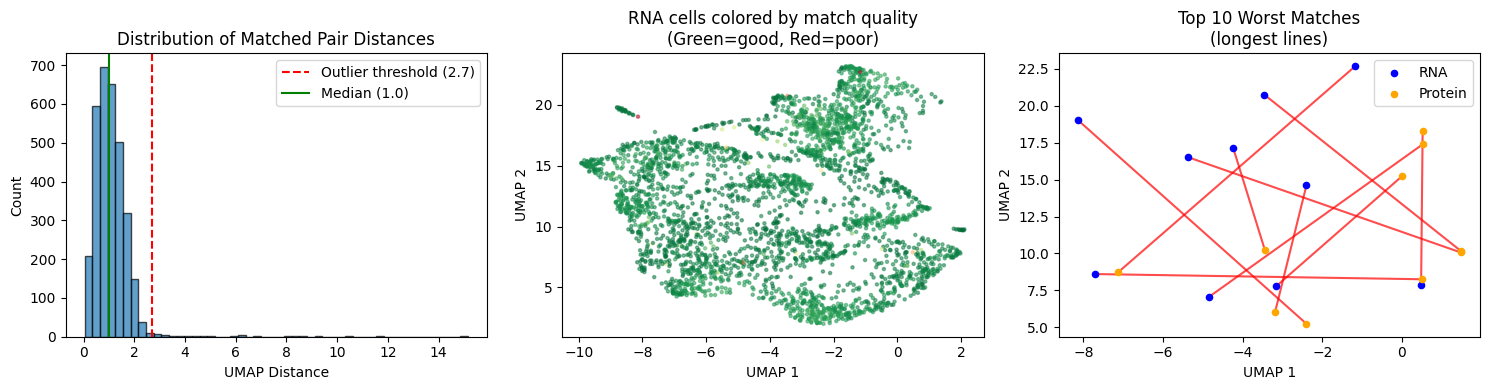


RECOMMENDATIONS

✓ LOW OUTLIER RATE (<5%)
   Integration quality looks good!

To filter outliers, you could add:
   good_matches = pair_dist_df[pair_dist_df['distance'] <= 2.7]

MARKER EXPRESSION IN OUTLIER PAIRS

Analyzing 41 outlier pairs...

Mean expression in OUTLIERS vs ALL matched pairs:
Marker              Outliers    All Pairs   Difference
-------------------------------------------------------
CD45/PTPRC             1.234        1.214       +0.020
CD3/CD3E               0.252        0.237       +0.016
CD20/MS4A1             1.110        0.710       +0.400
CD8/CD8A               0.058        0.101       -0.043
CD68                   0.243        0.479       -0.236
CD31/PECAM1            0.168        0.159       +0.010

Outlier pairs tend to be cells with:
  - HIGHER CD20/MS4A1 expression
  - LOWER CD68 expression

Protein marker expression in outlier-matched CODEX cells:
Protein          Outliers  All Matches
----------------------------------------
CD45               10.874  

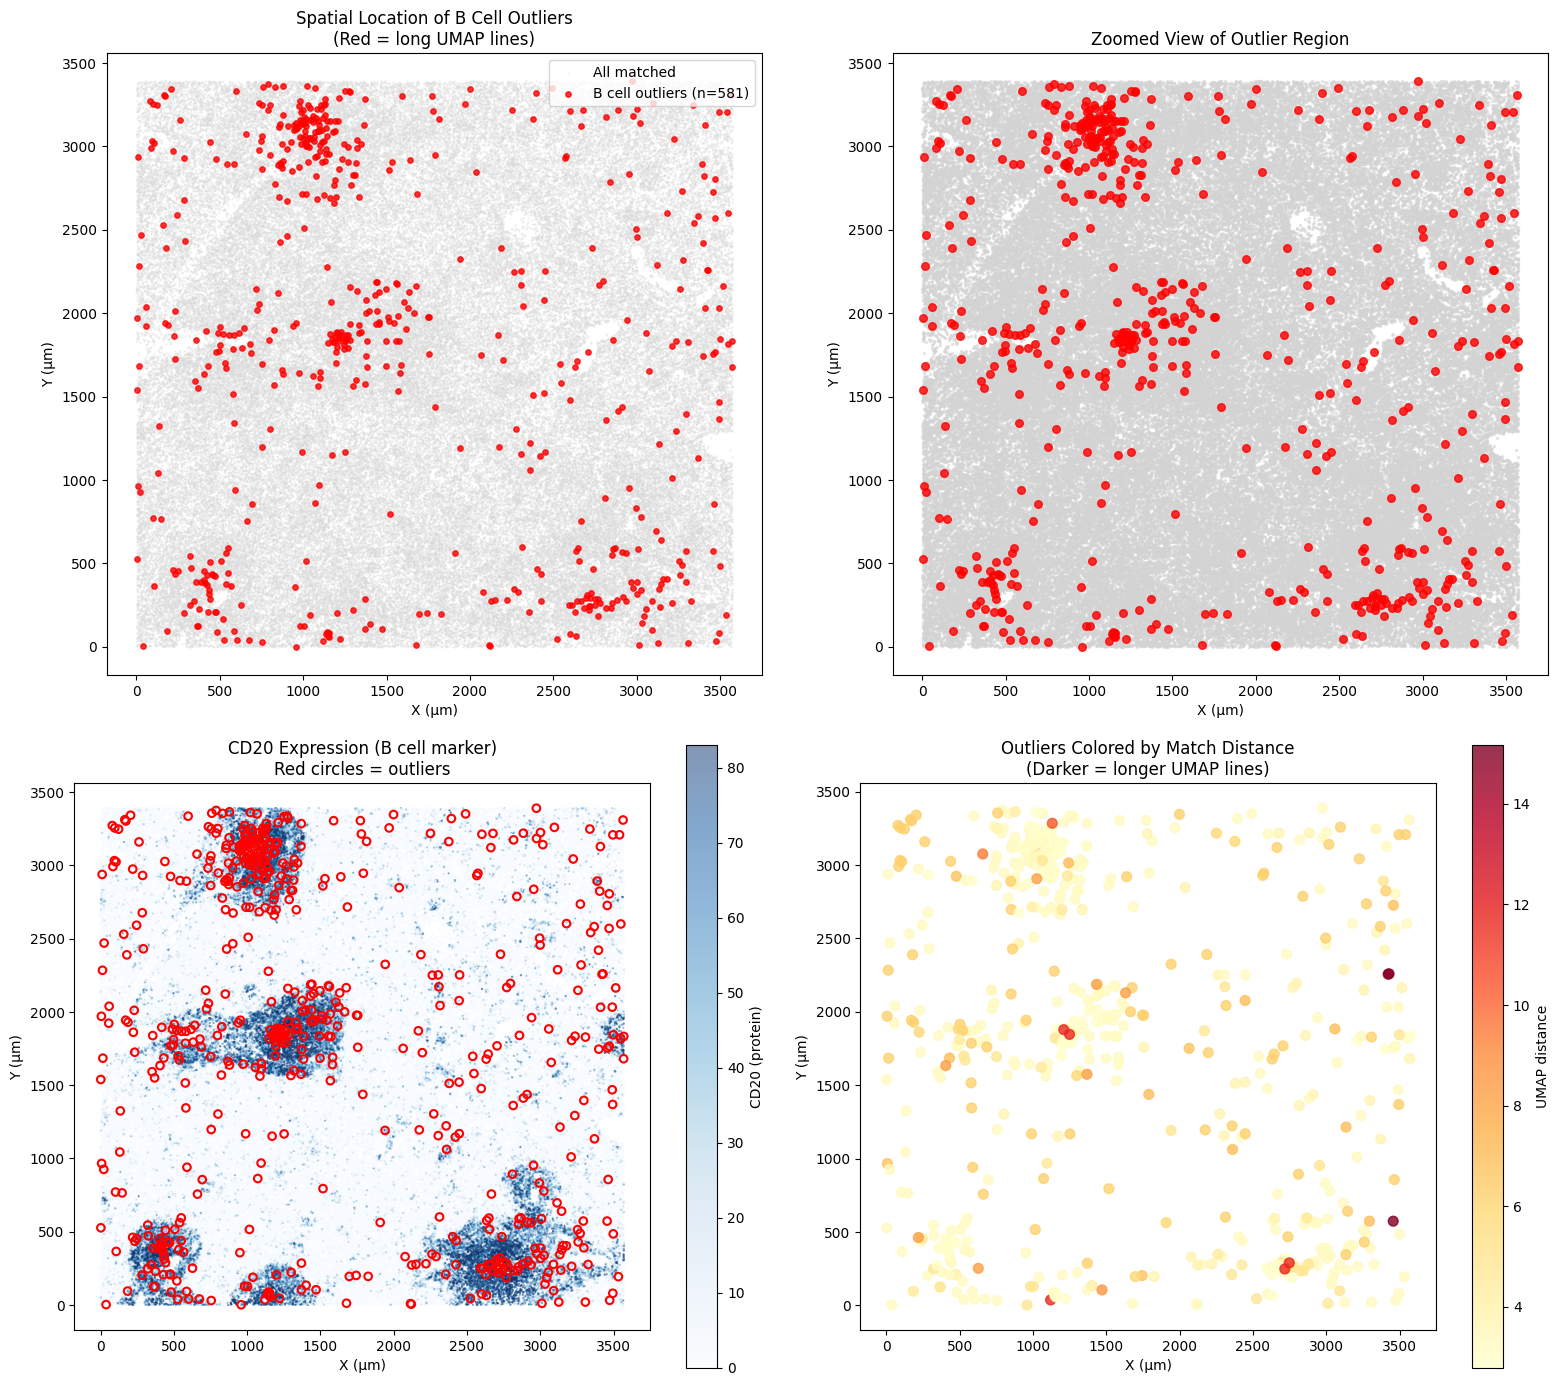


Spatial distribution of outliers:
  X range: 2 - 3570 µm
  Y range: 2 - 3389 µm
  Center: (1212, 1883) µm

  Median pairwise distance (outliers): 1873 µm
  Median pairwise distance (all cells): 1763 µm

  → Outliers have similar spatial spread as other cells

Figure saved to: spleen_outlier_spatial.png


In [76]:
# DIAGNOSTIC: Investigate long connecting lines (potential mismatches)
print("="*60)
print("MATCHED PAIR DISTANCE ANALYSIS")
print("="*60)

# Calculate distances for all matched pairs
umap_coords = cca_adata.obsm['X_umap']
n_pairs = len(rna_cca_scores)

pair_distances = []
for i in range(n_pairs):
    rna_umap = umap_coords[i]
    prot_umap = umap_coords[n_pairs + i]
    dist = np.linalg.norm(rna_umap - prot_umap)
    pair_distances.append({
        'pair_idx': i,
        'rna_idx': aligned_rna_indices[i],
        'distance': dist,
        'rna_umap_x': rna_umap[0],
        'rna_umap_y': rna_umap[1],
        'prot_umap_x': prot_umap[0],
        'prot_umap_y': prot_umap[1]
    })

pair_dist_df = pd.DataFrame(pair_distances)

# Statistics
print(f"\nDistance Statistics (all {n_pairs} matched pairs):")
print(f"  Mean:   {pair_dist_df['distance'].mean():.2f}")
print(f"  Median: {pair_dist_df['distance'].median():.2f}")
print(f"  Std:    {pair_dist_df['distance'].std():.2f}")
print(f"  Min:    {pair_dist_df['distance'].min():.2f}")
print(f"  Max:    {pair_dist_df['distance'].max():.2f}")

# Identify outliers (>2 std from mean)
threshold = pair_dist_df['distance'].mean() + 2 * pair_dist_df['distance'].std()
outliers = pair_dist_df[pair_dist_df['distance'] > threshold]
print(f"\nOutliers (distance > {threshold:.2f}): {len(outliers)} pairs ({100*len(outliers)/n_pairs:.1f}%)")

# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of distances
axes[0].hist(pair_dist_df['distance'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Outlier threshold ({threshold:.1f})')
axes[0].axvline(pair_dist_df['distance'].median(), color='green', linestyle='-', label=f'Median ({pair_dist_df["distance"].median():.1f})')
axes[0].set_xlabel('UMAP Distance')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Matched Pair Distances')
axes[0].legend()

# UMAP colored by match quality
match_quality = 1 - (pair_dist_df['distance'] / pair_dist_df['distance'].max())
axes[1].scatter(pair_dist_df['rna_umap_x'], pair_dist_df['rna_umap_y'], 
                c=match_quality, cmap='RdYlGn', s=5, alpha=0.5)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('RNA cells colored by match quality\n(Green=good, Red=poor)')

# Show worst matches
if len(outliers) > 0:
    worst_10 = pair_dist_df.nlargest(min(10, len(outliers)), 'distance')
    for _, row in worst_10.iterrows():
        axes[2].plot([row['rna_umap_x'], row['prot_umap_x']], 
                     [row['rna_umap_y'], row['prot_umap_y']], 
                     'r-', alpha=0.7, linewidth=1.5)
    axes[2].scatter(worst_10['rna_umap_x'], worst_10['rna_umap_y'], c='blue', s=20, label='RNA', zorder=5)
    axes[2].scatter(worst_10['prot_umap_x'], worst_10['prot_umap_y'], c='orange', s=20, label='Protein', zorder=5)
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].set_title(f'Top {len(worst_10)} Worst Matches\n(longest lines)')
    axes[2].legend()

plt.tight_layout()
plt.show()

# Recommendations
print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
if len(outliers) / n_pairs > 0.1:
    print("\n⚠️  HIGH OUTLIER RATE (>10%)")
    print("   Consider:")
    print("   1. Increase filter_prop in MaxFuse to remove more bad matches")
    print("   2. Check if specific cell types are causing mismatches")
    print("   3. Verify shared feature quality between modalities")
elif len(outliers) / n_pairs > 0.05:
    print("\n⚡ MODERATE OUTLIER RATE (5-10%)")
    print("   Some mismatches are normal. Consider filtering worst matches.")
else:
    print("\n✓ LOW OUTLIER RATE (<5%)")
    print("   Integration quality looks good!")

# Optional: Filter out worst matches
print(f"\nTo filter outliers, you could add:")
print(f"   good_matches = pair_dist_df[pair_dist_df['distance'] <= {threshold:.1f}]")

# ADDITIONAL ANALYSIS: Marker expression in outlier pairs
print("\n" + "="*60)
print("MARKER EXPRESSION IN OUTLIER PAIRS")
print("="*60)

if len(outliers) > 0:
    # Get the RNA indices for outliers
    outlier_rna_indices = [aligned_rna_indices[idx] for idx in outliers['pair_idx'].values]
    
    # Key markers to check
    markers_to_check = {
        'CD45/PTPRC': 'PTPRC',
        'CD3/CD3E': 'CD3E', 
        'CD20/MS4A1': 'MS4A1',
        'CD8/CD8A': 'CD8A',
        'CD68': 'CD68',
        'CD31/PECAM1': 'PECAM1',
    }
    
    print(f"\nAnalyzing {len(outliers)} outlier pairs...")
    print(f"\nMean expression in OUTLIERS vs ALL matched pairs:")
    print(f"{'Marker':<15} {'Outliers':>12} {'All Pairs':>12} {'Difference':>12}")
    print("-"*55)
    
    marker_diffs = []
    for marker_name, rna_gene in markers_to_check.items():
        if rna_gene in rna_adata_lognorm.var_names:
            gene_idx = list(rna_adata_lognorm.var_names).index(rna_gene)
            all_vals = rna_adata_lognorm.X[:, gene_idx]
            if hasattr(all_vals, 'toarray'):
                all_vals = all_vals.toarray().flatten()
            
            # Expression in outlier RNA cells
            outlier_expr = all_vals[outlier_rna_indices].mean()
            # Expression in all matched RNA cells  
            all_matched_expr = all_vals[aligned_rna_indices].mean()
            
            diff = outlier_expr - all_matched_expr
            marker_diffs.append((marker_name, outlier_expr, all_matched_expr, diff))
            print(f"{marker_name:<15} {outlier_expr:>12.3f} {all_matched_expr:>12.3f} {diff:>+12.3f}")
    
    # Find which markers are most different in outliers
    marker_diffs.sort(key=lambda x: abs(x[3]), reverse=True)
    
    print(f"\nOutlier pairs tend to be cells with:")
    for name, out_expr, all_expr, diff in marker_diffs[:3]:
        if abs(diff) > 0.1:
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(f"  - {direction} {name} expression")
    
    # Show protein expression for corresponding matched protein cells
    print(f"\nProtein marker expression in outlier-matched CODEX cells:")
    prot_markers = ['CD45', 'CD3e', 'CD20', 'CD8', 'CD68', 'CD31']
    available_prot = [m for m in prot_markers if m in protein_adata.var_names]
    
    if available_prot:
        # Get protein indices for outliers
        outlier_prot_indices = []
        for pair_idx in outliers['pair_idx'].values:
            rna_idx = aligned_rna_indices[pair_idx]
            if rna_idx in rna_to_prot_matches:
                prot_idx = rna_to_prot_matches[rna_idx][0][0]  # First match
                outlier_prot_indices.append(prot_idx)
        
        print(f"{'Protein':<12} {'Outliers':>12} {'All Matches':>12}")
        print("-"*40)
        for marker in available_prot:
            prot_idx = list(protein_adata.var_names).index(marker)
            outlier_prot_expr = protein_adata.X[outlier_prot_indices, prot_idx].mean()
            all_prot_expr = protein_adata.X[:, prot_idx].mean()
            print(f"{marker:<12} {outlier_prot_expr:>12.3f} {all_prot_expr:>12.3f}")

    # Note: Cluster distribution analysis available after running Harmony (cells below)
    print(f"\nNote: Run Harmony batch correction cells below for cluster analysis of outliers")
else:
    print("No outliers to analyze!")

# SPATIAL VISUALIZATION: Where are the B cell outliers?
print("\n" + "="*60)
print("SPATIAL LOCATION OF OUTLIER PAIRS")
print("="*60)

if len(outliers) > 0:
    # Get spatial coordinates for outlier protein cells
    outlier_spatial = []
    for pair_idx in outliers['pair_idx'].values:
        rna_idx = aligned_rna_indices[pair_idx]
        if rna_idx in rna_to_prot_matches:
            for prot_idx, score in rna_to_prot_matches[rna_idx]:
                outlier_spatial.append({
                    'x': protein_adata.obs['X_centroid'].values[prot_idx],
                    'y': protein_adata.obs['Y_centroid'].values[prot_idx],
                    'prot_idx': prot_idx,
                    'rna_idx': rna_idx,
                    'distance': outliers[outliers['pair_idx'] == pair_idx]['distance'].values[0]
                })
    
    outlier_spatial_df = pd.DataFrame(outlier_spatial)
    
    # Create spatial_df for all matched cells (needed for background plotting)
    all_spatial = []
    for rna_idx, matches in rna_to_prot_matches.items():
        for prot_idx, score in matches:
            all_spatial.append({
                'x': protein_adata.obs['X_centroid'].values[prot_idx],
                'y': protein_adata.obs['Y_centroid'].values[prot_idx],
                'protein_idx': prot_idx,
                'rna_idx': rna_idx
            })
    spatial_df = pd.DataFrame(all_spatial)
    
    # Create figure with multiple views
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Panel 1: All cells with outliers highlighted
    ax = axes[0, 0]
    # Plot all matched cells in gray
    ax.scatter(spatial_df['x'], spatial_df['y'], c='lightgray', s=0.5, alpha=0.3, label='All matched')
    # Highlight outliers in red
    ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], c='red', s=15, alpha=0.8, 
               label=f'B cell outliers (n={len(outlier_spatial_df)})', zorder=5)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Spatial Location of B Cell Outliers\n(Red = long UMAP lines)')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    
    # Panel 2: Zoom into region with most outliers
    ax = axes[0, 1]
    # Find the densest region of outliers
    x_center = outlier_spatial_df['x'].median()
    y_center = outlier_spatial_df['y'].median()
    x_range = outlier_spatial_df['x'].std() * 4
    y_range = outlier_spatial_df['y'].std() * 4
    
    # Plot zoomed region
    zoom_mask = (
        (spatial_df['x'] > x_center - x_range) & (spatial_df['x'] < x_center + x_range) &
        (spatial_df['y'] > y_center - y_range) & (spatial_df['y'] < y_center + y_range)
    )
    ax.scatter(spatial_df.loc[zoom_mask, 'x'], spatial_df.loc[zoom_mask, 'y'], 
               c='lightgray', s=2, alpha=0.5)
    
    zoom_outliers = (
        (outlier_spatial_df['x'] > x_center - x_range) & (outlier_spatial_df['x'] < x_center + x_range) &
        (outlier_spatial_df['y'] > y_center - y_range) & (outlier_spatial_df['y'] < y_center + y_range)
    )
    ax.scatter(outlier_spatial_df.loc[zoom_outliers, 'x'], outlier_spatial_df.loc[zoom_outliers, 'y'], 
               c='red', s=30, alpha=0.8, zorder=5)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Zoomed View of Outlier Region')
    ax.set_aspect('equal')
    
    # Panel 3: CD20 expression across tissue with outliers marked
    ax = axes[1, 0]
    if 'CD20' in protein_adata.var_names:
        cd20_idx = list(protein_adata.var_names).index('CD20')
        # Get CD20 expression for all matched protein cells
        cd20_vals = []
        for idx in spatial_df['protein_idx'].values:
            cd20_vals.append(protein_adata.X[idx, cd20_idx])
        
        scatter = ax.scatter(spatial_df['x'], spatial_df['y'], c=cd20_vals, 
                            cmap='Blues', s=0.5, alpha=0.5, vmin=0, vmax=np.percentile(cd20_vals, 95))
        ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], 
                   facecolors='none', edgecolors='red', s=30, linewidth=1.5, label='Outliers', zorder=5)
        plt.colorbar(scatter, ax=ax, label='CD20 (protein)')
        ax.set_xlabel('X (µm)')
        ax.set_ylabel('Y (µm)')
        ax.set_title('CD20 Expression (B cell marker)\nRed circles = outliers')
        ax.set_aspect('equal')
    
    # Panel 4: Outliers colored by match distance
    ax = axes[1, 1]
    scatter = ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], 
                        c=outlier_spatial_df['distance'], cmap='YlOrRd', s=50, alpha=0.8)
    plt.colorbar(scatter, ax=ax, label='UMAP distance')
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Outliers Colored by Match Distance\n(Darker = longer UMAP lines)')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('spleen_outlier_spatial.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print(f"\nSpatial distribution of outliers:")
    print(f"  X range: {outlier_spatial_df['x'].min():.0f} - {outlier_spatial_df['x'].max():.0f} µm")
    print(f"  Y range: {outlier_spatial_df['y'].min():.0f} - {outlier_spatial_df['y'].max():.0f} µm")
    print(f"  Center: ({outlier_spatial_df['x'].median():.0f}, {outlier_spatial_df['y'].median():.0f}) µm")
    
    # Check if outliers are clustered or dispersed
    from scipy.spatial.distance import pdist
    if len(outlier_spatial_df) > 2:
        outlier_coords = outlier_spatial_df[['x', 'y']].values
        all_coords = spatial_df[['x', 'y']].sample(min(1000, len(spatial_df))).values
        
        outlier_spread = np.median(pdist(outlier_coords))
        all_spread = np.median(pdist(all_coords))
        
        print(f"\n  Median pairwise distance (outliers): {outlier_spread:.0f} µm")
        print(f"  Median pairwise distance (all cells): {all_spread:.0f} µm")
        
        if outlier_spread < all_spread * 0.7:
            print("\n  → Outliers are SPATIALLY CLUSTERED (likely in B cell zones)")
        elif outlier_spread > all_spread * 1.3:
            print("\n  → Outliers are SPATIALLY DISPERSED")
        else:
            print("\n  → Outliers have similar spatial spread as other cells")
    
    print("\nFigure saved to: spleen_outlier_spatial.png")
else:
    print("No outliers to visualize!")

## Step 10: Cluster and Transfer Labels to Spatial Coordinates

Using the Harmony-corrected joint embedding:
1. Cluster cells across both modalities
2. Annotate clusters using RNA marker expression
3. Transfer cluster labels to CODEX spatial coordinates

In [ ]:
# Cluster using the Harmony-corrected joint embedding
# Use the final harmony-corrected embedding for clustering
sc.tl.leiden(cca_adata_harmony, resolution=1.0)

print(f"Found {len(cca_adata_harmony.obs['leiden'].unique())} clusters")

# Visualize clusters
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(cca_adata_harmony, color='leiden', ax=ax, show=False,
           title='Leiden Clusters (Harmony-corrected embedding)')
plt.tight_layout()
plt.show()

# Check cluster agreement between matched RNA and Protein cells
n_pairs = len(rna_cca_scores)
rna_clusters = cca_adata_harmony.obs['leiden'].values[:n_pairs]
prot_clusters = cca_adata_harmony.obs['leiden'].values[n_pairs:]
agreement = (rna_clusters == prot_clusters).sum() / n_pairs * 100

print(f"\nCluster agreement between matched pairs: {agreement:.1f}%")
if agreement > 80:
    print("  GOOD: High agreement indicates successful integration")
elif agreement > 50:
    print("  MODERATE: Some integration achieved")
else:
    print("  WARNING: Low agreement suggests integration issues")

In [ ]:
# Create a mapping from aligned RNA indices to cluster labels
rna_idx_to_cluster = dict(zip(aligned_rna_indices, rna_clusters))

# Key markers for cell type identification in spleen
cell_type_markers = [
    'CD3E', 'CD4', 'CD8A',           # T cells
    'MS4A1', 'CD19',                  # B cells
    'CD14', 'CD68', 'CD163',          # Monocytes/Macrophages
    'PECAM1', 'CD34',                 # Endothelial
    'PTPRC',                          # Pan-leukocyte (CD45)
]

# Filter to available markers
available_markers = [m for m in cell_type_markers if m in rna_adata_lognorm.var_names]
print(f"Available markers for annotation: {len(available_markers)}")
print(f"  {available_markers}")

In [ ]:
# Transfer cluster labels to CODEX spatial coordinates
spatial_records = []
for rna_idx, matches in rna_to_prot_matches.items():
    cluster = rna_idx_to_cluster.get(rna_idx)
    if cluster is None:
        continue
    for prot_idx, score in matches:
        spatial_records.append({
            'x': protein_adata.obs['X_centroid'].values[prot_idx],
            'y': protein_adata.obs['Y_centroid'].values[prot_idx],
            'rna_idx': rna_idx,
            'protein_idx': prot_idx,
            'match_score': score,
            'cluster': cluster
        })

spatial_df = pd.DataFrame(spatial_records)
print(f"Spatial mapping: {len(spatial_df)} cells with cluster labels")
print(f"Unique protein cells: {spatial_df['protein_idx'].nunique()}")
print(f"\nCluster distribution:")
print(spatial_df['cluster'].value_counts().sort_index())

# Plot clusters on spatial coordinates
from matplotlib import cm

unique_clusters = sorted(spatial_df['cluster'].unique())
n_clusters = len(unique_clusters)
colors = cm.tab20(np.linspace(0, 1, max(20, n_clusters)))
cluster_colors = {c: colors[i % 20] for i, c in enumerate(unique_clusters)}

# Subsample for plotting if needed
plot_df = spatial_df if len(spatial_df) <= 50000 else spatial_df.sample(n=50000, random_state=42)

plt.figure(figsize=(12, 12))
for cluster in unique_clusters:
    mask = plot_df['cluster'] == cluster
    plt.scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                c=[cluster_colors[cluster]], s=1, alpha=0.5, label=f'Cluster {cluster}')

plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.title('RNA Clusters Transferred to CODEX Spatial Coordinates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Step 10b: Harmony Batch Correction for Modality Mixing

**Harmony** is specifically designed to remove batch effects while preserving biological signal. 
Here we treat "modality" as a batch variable to force RNA and Protein cells to mix in the embedding.

This is the standard approach used in Seurat v3+ and other popular integration methods.

In [64]:
# Install and import harmony if needed
try:
    import harmonypy as hm
    print("Harmony loaded successfully")
except ImportError:
    print("Installing harmonypy...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'harmonypy', '-q'])
    import harmonypy as hm
    print("Harmony installed and loaded")

Harmony loaded successfully


In [65]:
# Run Harmony on the stacked CCA embedding to mix modalities
# This treats 'modality' as a batch variable and iteratively corrects for it

print("Running Harmony batch correction...")
print("This will force RNA and Protein cells to mix while preserving biological clusters.\n")

# Create a fresh copy for Harmony
cca_adata_harmony = cca_adata.copy()

# Run Harmony - key parameter is theta (diversity clustering penalty)
# Higher theta = more aggressive mixing
harmony_out = hm.run_harmony(
    cca_adata_harmony.X,                    # The CCA embedding
    cca_adata_harmony.obs,                   # Metadata
    'modality',                              # Batch variable to correct
    theta=2.0,                               # Diversity penalty (default=2, higher=more mixing)
    max_iter_harmony=20,                     # Max iterations
    verbose=True
)

# Store corrected embedding
cca_adata_harmony.obsm['X_harmony'] = harmony_out.Z_corr.T

print(f"\nHarmony correction complete!")
print(f"Corrected embedding shape: {cca_adata_harmony.obsm['X_harmony'].shape}")

2025-12-26 19:26:12,242 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony batch correction...
This will force RNA and Protein cells to mix while preserving biological clusters.



2025-12-26 19:26:12,623 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-26 19:26:12,635 - harmonypy - INFO - Iteration 1 of 20
2025-12-26 19:26:13,060 - harmonypy - INFO - Iteration 2 of 20
2025-12-26 19:26:13,484 - harmonypy - INFO - Iteration 3 of 20
2025-12-26 19:26:13,785 - harmonypy - INFO - Iteration 4 of 20
2025-12-26 19:26:14,199 - harmonypy - INFO - Converged after 4 iterations



Harmony correction complete!
Corrected embedding shape: (6422, 20)


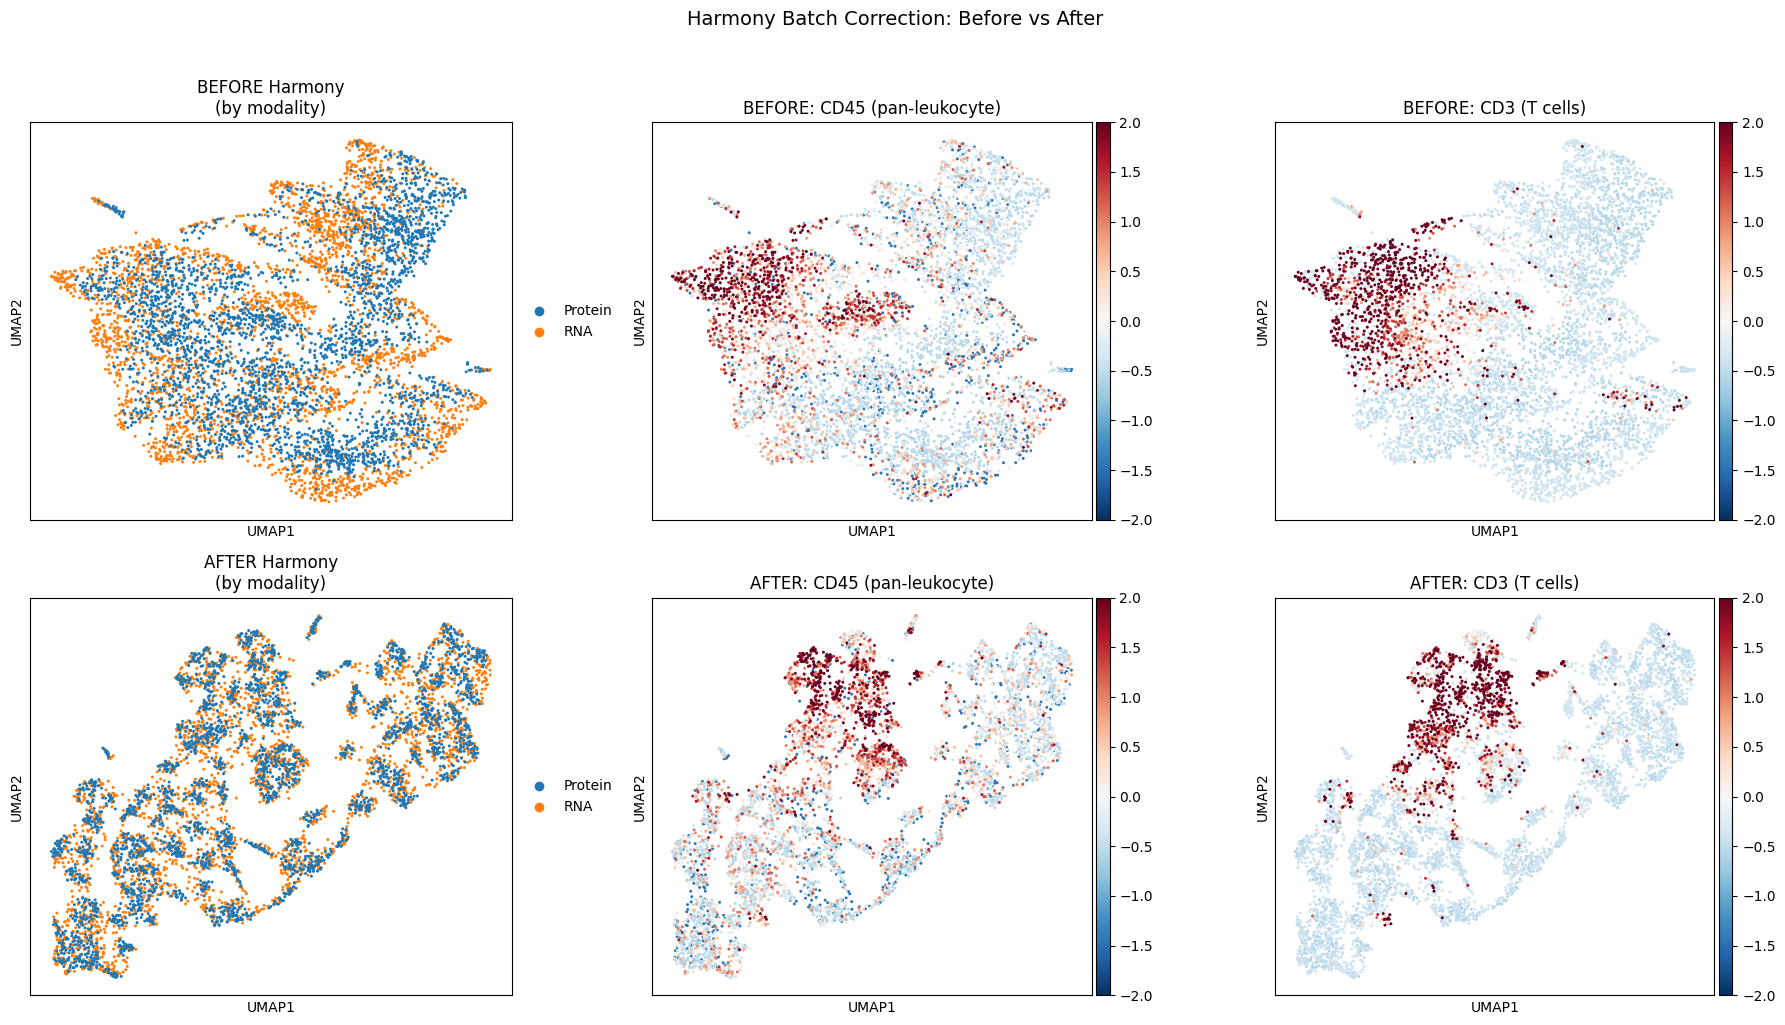


Matched pair distances (UMAP space):
  BEFORE Harmony - Mean: 1.10, Median: 1.00
  AFTER Harmony  - Mean: 0.45, Median: 0.27

  Improvement: 58.8% reduction in matched pair distance


In [71]:
# Compute UMAP on Harmony-corrected embedding and compare with original
sc.pp.neighbors(cca_adata_harmony, n_neighbors=15, use_rep='X_harmony')
sc.tl.umap(cca_adata_harmony)

# Compare BEFORE and AFTER Harmony
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Before Harmony (original CCA stacked)
sc.pl.umap(cca_adata, color='modality', ax=axes[0, 0], show=False, 
           title='BEFORE Harmony\n(by modality)')

# Add marker expression to cca_adata if not already there
if 'CD45' not in cca_adata.obs.columns:
    # Add markers from matched data
    n_rna_emb = len(rna_cca_scores)
    marker_map = {'CD45': 'PTPRC', 'CD3e': 'CD3E'}
    for prot_marker, rna_gene in marker_map.items():
        marker_vals = np.zeros(cca_adata.n_obs)
        if rna_gene in rna_adata_lognorm.var_names:
            rna_idx = list(rna_adata_lognorm.var_names).index(rna_gene)
            rna_vals = rna_adata_lognorm.X[:, rna_idx]
            if sparse.issparse(rna_vals):
                rna_vals = rna_vals.toarray().flatten()
            marker_vals[:n_rna_emb] = rna_vals[aligned_rna_indices]
        if prot_marker in protein_adata.var_names:
            prot_idx = list(protein_adata.var_names).index(prot_marker)
            for i, rna_idx in enumerate(aligned_rna_indices):
                prot_indices = [m[0] for m in rna_to_prot_matches[rna_idx]]
                marker_vals[n_rna_emb + i] = protein_adata.X[prot_indices, prot_idx].mean()
        # Z-score per modality
        rna_part = marker_vals[:n_rna_emb]
        prot_part = marker_vals[n_rna_emb:]
        if rna_part.std() > 0:
            marker_vals[:n_rna_emb] = (rna_part - rna_part.mean()) / rna_part.std()
        if prot_part.std() > 0:
            marker_vals[n_rna_emb:] = (prot_part - prot_part.mean()) / prot_part.std()
        cca_adata.obs[prot_marker] = marker_vals

# Copy markers to harmony version
for marker in ['CD45', 'CD3e']:
    if marker in cca_adata.obs.columns:
        cca_adata_harmony.obs[marker] = cca_adata.obs[marker].values

sc.pl.umap(cca_adata, color='CD45', ax=axes[0, 1], show=False,
           title='BEFORE: CD45 (pan-leukocyte)', cmap='RdBu_r', vmin=-2, vmax=2)
sc.pl.umap(cca_adata, color='CD3e', ax=axes[0, 2], show=False,
           title='BEFORE: CD3 (T cells)', cmap='RdBu_r', vmin=-2, vmax=2)

# Row 2: After Harmony
sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[1, 0], show=False,
           title='AFTER Harmony\n(by modality)')
sc.pl.umap(cca_adata_harmony, color='CD45', ax=axes[1, 1], show=False,
           title='AFTER: CD45 (pan-leukocyte)', cmap='RdBu_r', vmin=-2, vmax=2)
sc.pl.umap(cca_adata_harmony, color='CD3e', ax=axes[1, 2], show=False,
           title='AFTER: CD3 (T cells)', cmap='RdBu_r', vmin=-2, vmax=2)

plt.suptitle('Harmony Batch Correction: Before vs After', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Quantify improvement in matched pair distances
umap_before = cca_adata.obsm['X_umap']
umap_after = cca_adata_harmony.obsm['X_umap']
n_pairs = len(rna_cca_scores)

dist_before = np.linalg.norm(umap_before[:n_pairs] - umap_before[n_pairs:], axis=1)
dist_after = np.linalg.norm(umap_after[:n_pairs] - umap_after[n_pairs:], axis=1)

print(f"\nMatched pair distances (UMAP space):")
print(f"  BEFORE Harmony - Mean: {dist_before.mean():.2f}, Median: {np.median(dist_before):.2f}")
print(f"  AFTER Harmony  - Mean: {dist_after.mean():.2f}, Median: {np.median(dist_after):.2f}")
improvement = (dist_before.mean() - dist_after.mean()) / dist_before.mean() * 100
print(f"\n  Improvement: {improvement:.1f}% reduction in matched pair distance")

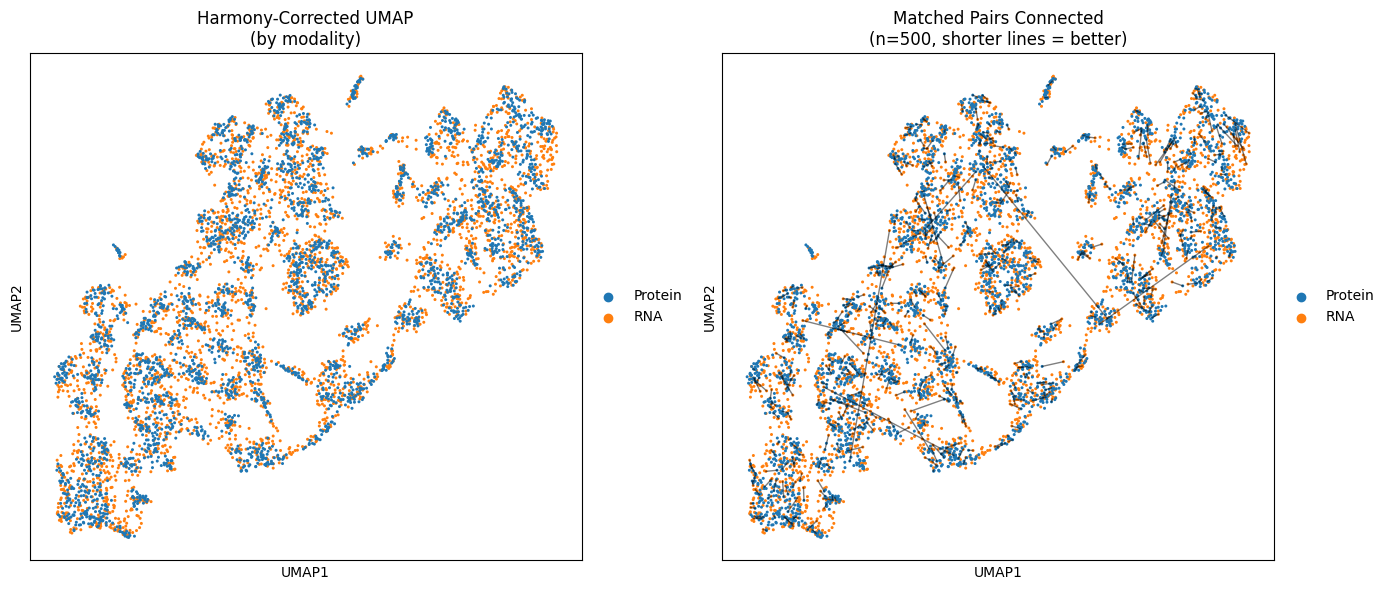


Integration Quality Metrics (Harmony-corrected):
  kNN accuracy (k=50): 99.1% of RNA cells have their matched protein in top-50 neighbors
  kNN accuracy (k=50): 78.6% of Protein cells have their matched RNA in top-50 neighbors
  Average: 88.9%


In [72]:
# Show matched pairs with connecting lines in Harmony-corrected UMAP
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Harmony UMAP with modality coloring
sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[0], show=False,
           title='Harmony-Corrected UMAP\n(by modality)')

# Panel 2: Same with connecting lines
umap_harmony = cca_adata_harmony.obsm['X_umap']
n_pairs = len(rna_cca_scores)
n_show = 500

np.random.seed(42)
pair_sample = np.random.choice(n_pairs, min(n_show, n_pairs), replace=False)

for pair_idx in pair_sample:
    rna_pt = umap_harmony[pair_idx]
    prot_pt = umap_harmony[n_pairs + pair_idx]
    axes[1].plot([rna_pt[0], prot_pt[0]], [rna_pt[1], prot_pt[1]], 
                 'black', alpha=0.5, linewidth=1.0)

sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[1], show=False,
           title=f'Matched Pairs Connected\n(n={n_show}, shorter lines = better)')

plt.tight_layout()
plt.show()

# Calculate what percentage of matched pairs are within k neighbors
from sklearn.neighbors import NearestNeighbors

print("\nIntegration Quality Metrics (Harmony-corrected):")
print("="*60)

# kNN accuracy: what fraction of matched pairs are k-nearest neighbors?
knn = NearestNeighbors(n_neighbors=50)
knn.fit(cca_adata_harmony.obsm['X_harmony'])
distances, indices = knn.kneighbors(cca_adata_harmony.obsm['X_harmony'])

# For each RNA cell, check if its matched protein cell is in its k nearest neighbors
knn_hits = 0
for i in range(n_pairs):
    rna_neighbors = indices[i]
    matched_prot_idx = n_pairs + i  # The corresponding protein cell
    if matched_prot_idx in rna_neighbors:
        knn_hits += 1

knn_accuracy = knn_hits / n_pairs * 100
print(f"  kNN accuracy (k=50): {knn_accuracy:.1f}% of RNA cells have their matched protein in top-50 neighbors")

# Also check from protein side
knn_hits_prot = 0
for i in range(n_pairs):
    prot_neighbors = indices[n_pairs + i]
    matched_rna_idx = i
    if matched_rna_idx in prot_neighbors:
        knn_hits_prot += 1

knn_accuracy_prot = knn_hits_prot / n_pairs * 100
print(f"  kNN accuracy (k=50): {knn_accuracy_prot:.1f}% of Protein cells have their matched RNA in top-50 neighbors")
print(f"  Average: {(knn_accuracy + knn_accuracy_prot)/2:.1f}%")

## Step 10c: Enhanced Spatial Visualization

Create publication-quality spatial plots with:
- Cell type annotations based on marker expression
- Tissue region highlighting
- Multi-panel comparison views

In [ ]:
# Enhanced Spatial Visualization with Cell Type Annotation
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Build spatial dataframe from matching results (using variables from earlier cells)
# Use rna_to_prot_matches and rna_idx_to_cluster from previous cells
spatial_records = []
for rna_idx, matches in rna_to_prot_matches.items():
    cluster = rna_idx_to_cluster.get(rna_idx)
    if cluster is None:
        continue
    for prot_idx, score in matches:
        spatial_records.append({
            'x': protein_adata.obs['X_centroid'].values[prot_idx],
            'y': protein_adata.obs['Y_centroid'].values[prot_idx],
            'rna_idx': rna_idx,
            'protein_idx': prot_idx,
            'match_score': score,
            'cluster': cluster
        })

spatial_df_vis = pd.DataFrame(spatial_records)
print(f"Spatial mapping: {len(spatial_df_vis)} cells with cluster labels")

# Define cell type annotations based on marker expression patterns
cell_type_markers = {
    'T cell': ['CD3E', 'CD3e'],
    'B cell': ['MS4A1', 'CD20'],
    'Monocyte/Macrophage': ['CD68', 'CD14'],
    'Endothelial': ['PECAM1', 'CD31'],
}

# Simple cell type assignment based on cluster marker expression
# Get average marker expression per cluster from RNA data
cluster_annotations = {}
for cluster in spatial_df_vis['cluster'].unique():
    cluster_rna_indices = [rna_idx for rna_idx, c in rna_idx_to_cluster.items() if c == cluster]
    if len(cluster_rna_indices) == 0:
        cluster_annotations[cluster] = 'Other'
        continue
    
    best_type = 'Other'
    best_score = 0
    for cell_type, markers in cell_type_markers.items():
        score = 0
        for marker in markers:
            if marker in rna_adata_lognorm.var_names:
                marker_idx = list(rna_adata_lognorm.var_names).index(marker)
                vals = rna_adata_lognorm.X[cluster_rna_indices, marker_idx]
                if sparse.issparse(vals):
                    vals = vals.toarray()
                score += vals.mean()
        if score > best_score:
            best_score = score
            best_type = cell_type
    cluster_annotations[cluster] = best_type if best_score > 0.5 else 'Other'

# Add cell type to spatial data
spatial_df_vis['cell_type'] = spatial_df_vis['cluster'].map(
    lambda x: cluster_annotations.get(x, 'Unknown')
)

# Create color palette for cell types
cell_type_colors = {
    'T cell': '#E41A1C',       # Red
    'B cell': '#377EB8',       # Blue
    'Monocyte/Macrophage': '#4DAF4A',  # Green
    'Endothelial': '#984EA3',  # Purple
    'Other': '#999999',        # Gray
    'Unknown': '#CCCCCC',      # Light gray
}

# Plot
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Subsample for visualization
np.random.seed(42)
plot_df = spatial_df_vis if len(spatial_df_vis) <= 50000 else spatial_df_vis.sample(n=50000)

# Panel 1: By cluster
unique_clusters = sorted(plot_df['cluster'].unique())
cluster_cmap = cm.tab20(np.linspace(0, 1, max(20, len(unique_clusters))))
for i, cluster in enumerate(unique_clusters):
    mask = plot_df['cluster'] == cluster
    axes[0].scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                    c=[cluster_cmap[i % 20]], s=0.5, alpha=0.5, label=f'{cluster}')
axes[0].set_xlabel('X (µm)', fontsize=12)
axes[0].set_ylabel('Y (µm)', fontsize=12)
axes[0].set_title('Clusters from Joint Embedding', fontsize=14)
axes[0].set_aspect('equal')

# Panel 2: By cell type
for cell_type in cell_type_colors.keys():
    mask = plot_df['cell_type'] == cell_type
    if mask.sum() > 0:
        axes[1].scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                        c=cell_type_colors[cell_type], s=0.5, alpha=0.5, label=cell_type)
axes[1].set_xlabel('X (µm)', fontsize=12)
axes[1].set_ylabel('Y (µm)', fontsize=12)
axes[1].set_title('Cell Types (from RNA markers)', fontsize=14)
axes[1].legend(loc='upper right', markerscale=8, fontsize=10)
axes[1].set_aspect('equal')

# Panel 3: Match quality
scatter = axes[2].scatter(plot_df['x'], plot_df['y'],
                          c=plot_df['match_score'], s=0.5, alpha=0.5,
                          cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_xlabel('X (µm)', fontsize=12)
axes[2].set_ylabel('Y (µm)', fontsize=12)
axes[2].set_title('Match Confidence Score', fontsize=14)
axes[2].set_aspect('equal')
plt.colorbar(scatter, ax=axes[2], label='Score (higher=better)')

plt.tight_layout()
plt.savefig('results/3_visualization/spatial_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCell type distribution:")
print(spatial_df_vis['cell_type'].value_counts())

## Step 10d: MARIO vs MaxFuse Comparison

Compare the integration results from both methods:
- Matching coverage
- Canonical correlation quality
- Computational efficiency

In [ ]:
# MaxFuse Results Summary
print("="*70)
print("MAXFUSE INTEGRATION SUMMARY")
print("="*70)

# MaxFuse results (from loaded checkpoint)
n_maxfuse_rna = rna_active.shape[0]
n_maxfuse_prot = protein_active.shape[0]
n_maxfuse_matched_rna = len(np.unique(full_matching[0]))
n_maxfuse_matched_prot = len(np.unique(full_matching[1]))

print(f"\n1. DATA SCALE")
print(f"   RNA cells: {n_maxfuse_rna:,}")
print(f"   Protein cells: {n_maxfuse_prot:,}")

print(f"\n2. MATCHING COVERAGE")
print(f"   Total matches: {len(full_matching[0]):,}")
print(f"   Unique RNA cells matched: {n_maxfuse_matched_rna:,} ({100*n_maxfuse_matched_rna/n_maxfuse_rna:.1f}%)")
print(f"   Unique Protein cells matched: {n_maxfuse_matched_prot:,} ({100*n_maxfuse_matched_prot/n_maxfuse_prot:.1f}%)")
print(f"   Mean match score: {np.mean(full_matching[2]):.3f}")

print(f"\n3. EMBEDDING QUALITY")
if 'cancor' in dir():
    print(f"   Mean canonical correlation (top 5): {cancor[:5].mean():.3f}")

print(f"\n4. KEY NOTES")
print("   - MaxFuse uses graph smoothing and pivot-based propagation")
print("   - Scales well to large datasets (>100K cells)")
print("   - For MARIO comparison, see 2_integration.ipynb")

## Step 11: Save Results

Save the integration results for downstream analysis.

In [ ]:
# Save visualization results to results directory
import os

results_dir = 'results/3_visualization'
os.makedirs(results_dir, exist_ok=True)

# Save MaxFuse matching results (also in 2_integration, but good to have here)
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv(f'{results_dir}/maxfuse_matching.csv', index=False)
print(f"Saved MaxFuse matching to {results_dir}/maxfuse_matching.csv ({len(matching_df)} matches)")

# Save spatial mapping with cluster labels
spatial_df.to_csv(f'{results_dir}/spatial_clusters.csv', index=False)
print(f"Saved spatial clusters to {results_dir}/spatial_clusters.csv ({len(spatial_df)} records)")

# Save Harmony-corrected joint embedding
cca_adata_harmony.write(f'{results_dir}/joint_embedding_harmony.h5ad')
print(f"Saved joint embedding to {results_dir}/joint_embedding_harmony.h5ad")

# Save visualization parameters
vis_params = {
    'n_cca_components': n_cca_components,
    'n_matched_pairs': len(rna_cca_scores),
    'harmony_theta': 2.0,
    'leiden_resolution': 1.0
}
with open(f'{results_dir}/visualization_params.json', 'w') as f:
    json.dump(vis_params, f, indent=2)

print(f"\nAll outputs saved to {results_dir}/")
print("Run 4_multi_sample.ipynb or 5_analysis.ipynb next (optional).")